# Hands-on Day 4

## You'll learn

### ML methods

- Gradient Boosting Trees with xgboost

### ML techniques
- hyperparameter optimisation
- ROC curves

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [1]:
%reload_ext custom_functions
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [3]:
#inputFile = 'file:///home/jovyan/Higgs100k.parquet'
inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

CPU times: user 1.02 s, sys: 1.38 s, total: 2.4 s
Wall time: 396 ms


In [4]:
# The first column is the target variable
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

len(x)

999999

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
#sanity check

print(len(x_train)+len(x_test))
print(len(y_train)+len(y_test))

999999
999999


# ML model: GBT

- xgboost uses the parameter n_jobs to spawn multi-core jobs on the SAME machine
- do not abuse it or you'll eat up all resources (set it to 5 max)

In [7]:
# DO NOT Use all available cores NJOBS = -1 
NJOBS = 40

In [8]:
import xgboost as xgb

# Define the XGBoost classifier with multi-core support
gbt = xgb.XGBClassifier(
    n_estimators=100,      # Number of trees (can be adjusted)
    max_depth=6,           # Maximum depth of each tree (can be tuned)
    learning_rate=0.1,     # Learning rate (can be tuned)
    n_jobs=NJOBS,             # DO NOT Use all available cores
    verbosity=1            # Set verbosity level to monitor training progress
)

# Train the model
%time gbt.fit(x_train, y_train)

# Make predictions on the test set
y_pred = gbt.predict(x_test)

CPU times: user 1min 11s, sys: 1.12 s, total: 1min 12s
Wall time: 2.15 s


In [9]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7323
Precision: 0.7435
Recall: 0.7530
F1-Score: 0.7482


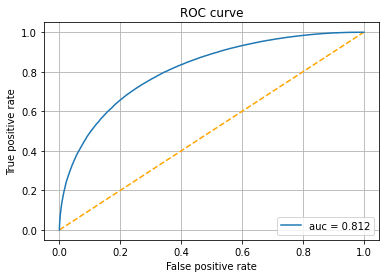

In [10]:
# Get predicted probabilities for the positive class
y_scores = gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

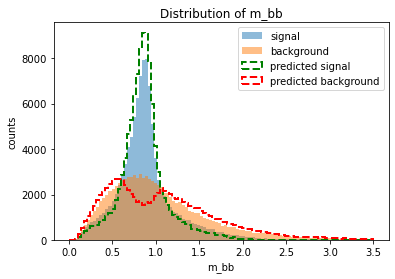

In [11]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

Feature Importance Ranking:
                     Feature  Importance
25                      m_bb    0.188022
26                     m_wbb    0.105003
27                    m_wwbb    0.101270
22                     m_jjj    0.085598
24                     m_jlv    0.080430
5                    jet1_pt    0.070138
3   missing_energy_magnitude    0.042783
8                 jet1_b-tag    0.042680
21                      m_jj    0.040106
0                  lepton_pT    0.033576
9                    jet2_pt    0.032845
16                jet3_b-tag    0.026152
23                      m_lv    0.023033
13                   jet3_pt    0.020136
20                jet4_b-tag    0.019972
17                   jet4_pt    0.016429
12                jet2_b-tag    0.016328
1                 lepton_eta    0.010333
6                   jet1_eta    0.010260
14                  jet3_eta    0.007452
18                   je4_eta    0.006838
10                  jet2_eta    0.006711
4         missing_energy_phi 

<Figure size 720x432 with 0 Axes>

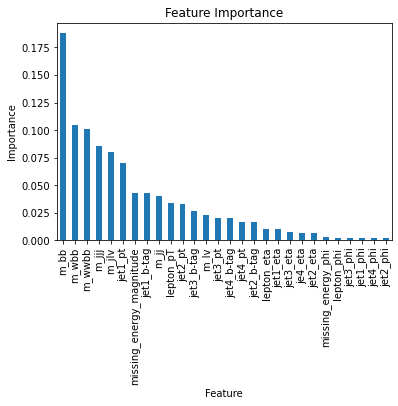

In [12]:
#draw feature importance
drawFeaturesXgb(x, gbt)

# Hyperparameter scan

In [13]:
# Get the default hyperparameters
default_params = gbt.get_params()

# Print the default hyperparameters
for param, value in default_params.items():
    print(f"{param}: {value}")

objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 6
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 100
n_jobs: 40
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: 1


## Exercise 1

- do hyperparameter optimisation using Randomized Grid search
- select a reasonable number and range of hyperparameters
- DO NOT USE all possible cores (check sklearn doc)
- while the code runs, check with top that there are indeed several python processes running
- check metrics (accuracy, ROC curve, signal vs background, feature ranking)

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=20, scoring='accuracy', cv=3, n_jobs=NJOBS, verbose=1, random_state=42)

# Run random search
%time random_search.fit(x_train, y_train)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/jovyan/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:42:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 6min 5s, sys: 6.47 s, total: 6min 11s
Wall time: 1min 37s
Best parameters found:  {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best accuracy:  0.7381809234128361


In [15]:
# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7400
Precision: 0.7505
Recall: 0.7607
F1-Score: 0.7556


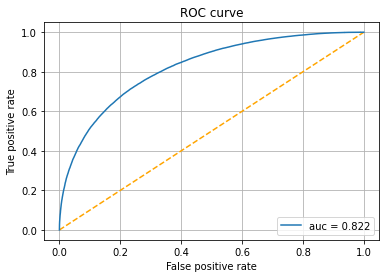

In [17]:
# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

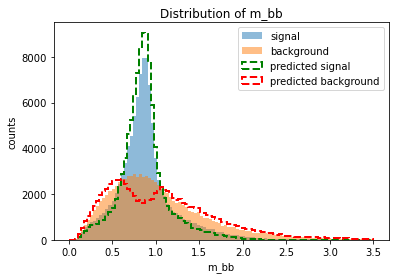

In [18]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

## Exercise 2

- Run the best model on full dataset

In [19]:
inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

CPU times: user 7.39 s, sys: 12.4 s, total: 19.8 s
Wall time: 823 ms


In [20]:
#create train/test set
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(y)

10000000

In [21]:
# Define the XGBoost classifier with multi-core support
best_gbt = xgb.XGBClassifier(
    n_estimators=100,      # Number of trees 
    max_depth=10,           # Maximum depth of each tree 
    learning_rate=0.05,     # Learning rate
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=NJOBS,             # DO NOT Use all available cores
    verbosity=1            # Set verbosity level to monitor training progress
)

# Train the model
%time best_gbt.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_gbt.predict(x_test)

CPU times: user 23min 2s, sys: 6.12 s, total: 23min 8s
Wall time: 38.4 s


In [22]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7424
Precision: 0.7537
Recall: 0.7630
F1-Score: 0.7583


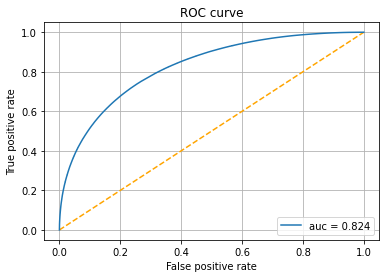

In [23]:
# Get predicted probabilities for the positive class
y_scores = best_gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

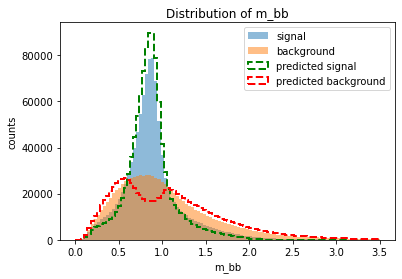

In [24]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

Feature Importance Ranking:
                     Feature  Importance
25                      m_bb    0.237782
27                    m_wwbb    0.113909
26                     m_wbb    0.093046
22                     m_jjj    0.083658
5                    jet1_pt    0.064611
24                     m_jlv    0.064053
21                      m_jj    0.040169
8                 jet1_b-tag    0.037955
0                  lepton_pT    0.036126
3   missing_energy_magnitude    0.035210
9                    jet2_pt    0.026825
20                jet4_b-tag    0.024917
12                jet2_b-tag    0.022790
16                jet3_b-tag    0.021550
23                      m_lv    0.019605
13                   jet3_pt    0.016376
17                   jet4_pt    0.015448
1                 lepton_eta    0.010396
6                   jet1_eta    0.008908
10                  jet2_eta    0.005768
18                   je4_eta    0.005478
14                  jet3_eta    0.005435
7                   jet1_phi 

<Figure size 720x432 with 0 Axes>

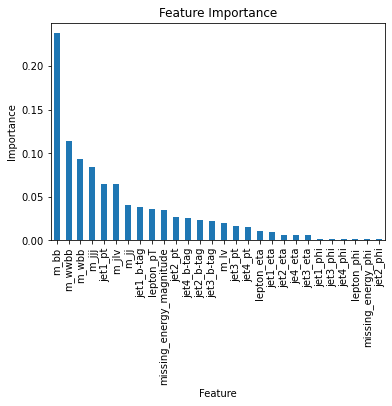

In [25]:
# draw feature importance
drawFeaturesXgb(x, best_gbt)